# First test
Updated conda environment, updated versions of openMM and openFF, newest openFF forcefield

In [9]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import get_mdfps, print_package_versions
print_package_versions()

ff_name: openff_unconstrained-2.1.0.offxml
ff_version:  0.14.3
simulation_type: tMD water solution
md_engine: openMM
version:  8.0
steps_time: 5.0
2023.03.3


md_experiment_uuids:
1. fc57851e-b654-4338-bcdd-faa28ec66253
2. 7a5837f2-e4ad-4e17-a2c3-6e5e956f938b
note that there are two uuis, one for the initial batch and one to fix some errors that resulted in crashes in the simulation. But in principal, these two are the same. 

- mdfp_experiment_uuid: fc57851e-b654-4338-bcdd-faa28ec66253
- confgen_uuid: 11093a30-b6d0-4e3f-a22b-8dcad60d6a11


In [11]:
import pandas as pd
df_mdfps = get_mdfps(which='one_5ns')
df_experimental = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/VP_data_no_duplicates.tsv', sep='\t')
print(len(df_experimental),' datapoints in experimental data')
print(len(df_experimental)-len(df_mdfps),' datapoints missing')

2993 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
3042  datapoints in experimental data
49  datapoints missing


At this point, there are some datapoints missing due to errors in the simulations. These will be discussed in Experiments_error_analysis/001_simu

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localho

RMSE:  1.3847943863480319
MAE:  0.8624140381722034
R2:  0.8537180390534396


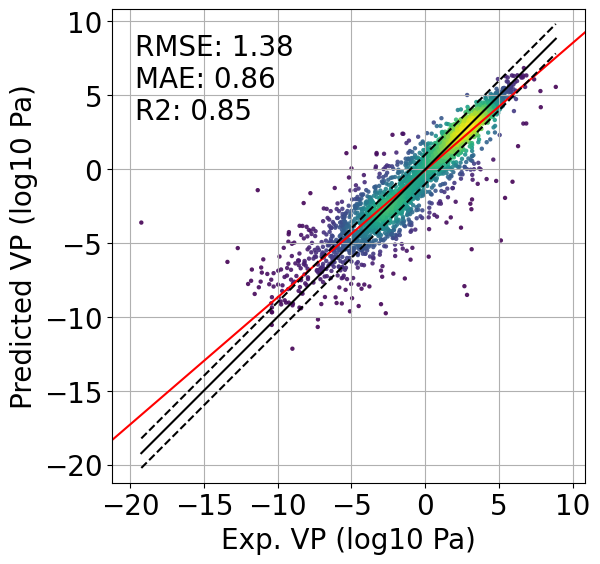

In [13]:
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot
from functools import reduce
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)
